# Cheaters demise code

The previous code defined the clusters of suspicious users, which were characterized as those who didn't watch (almost) any videos and documents and got all the answers right. These are thought to be users who deal with fake and real accounts, counting errors on the fakes and taking the right answers on the real ones.

Since there is a defined cluster of suspicious users, the following code will try to identify the activity of these users and see if they can be considered as cheaters or not, depending on timing and improvement. By taking into account that timing would be equal to the time difference between an answer from one user and the other, there may be a correlation between them, since after finding the real answer on a fake account, the user would input it into his real account in a short period. Also, improvement is a metric that can differentiate between a user that coincidently did it right after another and a cheater, by measuring if the user got the wrong answer or not. If it did get the wrong answer, than he's not using a fake account.

One course of action is to create a graph of exercise (i) by user(j) and the time it took the user to finish it.

## Clear environment

In [1]:
%reset -f

In [2]:
%matplotlib inline

In [3]:
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as ssd
import matplotlib.pyplot as plt
import collections as coll
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import sympy as sym
import numpy as np
import math
import json
import time
import sys
import os
from sklearn.cluster import AgglomerativeClustering
from multiprocessing import Process, Queue, Pool
from IPython.display import clear_output
from functools import partial
from ast import literal_eval

#if sys.platform == 'win32':
#    from signal import signal, SIG_DFL
#else:
#    from signal import signal, SIGPIPE, SIG_DFL
#signal(SIGPIPE, SIG_DFL)

# define date format
date_format = '%Y-%m-%d %H:%M:%S'

# number of exercises
N_EXERCISES = 196

# Time tolerance for exercises
tol = 2
trimming = tol #math.inf

cluster_tag = 'all'

# From the Main PIPE lib files:
#funcion que carga un fichero en un dataframe con el id del usuario en una columna y sus eventos en formato json en otra
def readDataFile(filename):
    # Leemos el fichero por lineas
    with open(filename) as f:
        users_events = f.readlines()
        
    # Parseamos a formato json cada linea
    listJson = list(map(json.loads, users_events));
   
    # Creamos el dataframe a partir de               
    df = pd.DataFrame.from_dict(listJson, orient='columns');
    return df

###
#---
###

# sort functions
def take_second(elem):
    return elem[1]

def take_third(elem):
    return elem[2]

def take_size(elem):
    return len(elem)
    
def generate_pairs(data_array, user_id_data, scores_data, trimming, label, plot):
    mpl.rcParams.update(mpl.rcParamsDefault)
    
    fig = plt.figure()
    
    user_pairs = []
    
    user_score_difference = []
    
    for i in range(0, len(data_array)):
        arrays = [[], [], [], []]           

        for j in range(0, 4):
            if(isinstance(data_array[i][1][j], list)):
                arrays[j] = calculateHistogram(data_array[i][1][j], trimming)
                user_1, user_2 = return_users(data_array[i][0])

        user_pairs.append((user_1, user_2))
            
        user1_id = int(user_id_data[user_1])
        user2_id = int(user_id_data[user_2])

        for p in range(0, len(scores_data)):
            if (user1_id == scores_data[p][0]):
                score1 = scores_data[p][1]

            if (user2_id == scores_data[p][0]):
                score2 = scores_data[p][1]

        user_score_difference.append(score1 - score2)
        
        if (plot):
            n = len(fig.axes)
            for o in range(n):
                fig.axes[o].change_geometry(n+1, 1, o+1)
            ax = fig.add_subplot(n+1, 1, n+1) 

            ax.set_title('User ' + str(user_1) + ' (' + str(user1_id) +': ' + str(score1) + ') vs User ' +
                          str(user_2) + ' (' + str(user2_id) +': ' + str(score2) + ')' + ' || Distance: '
                         + str(data_array[i][2]), fontsize=13)
            ax.set_xlabel('Time (minutes)')
            ax.set_ylabel('Number of occurences')
            ax.hist([arrays[0], arrays[1], arrays[2], arrays[3]], color=['blue', 'orange', 'green', 'red'],
                    label=label, bins=100, stacked=True)            
            ax.legend()

        clear_output(wait=True)
        print(math.ceil(i*100/len(data_array)), '% done')
    return user_pairs, user_score_difference, fig

def get_number_of_exercises(data, tol):
    #nbr_exercises_over = sum(((x >= 0) and (x < tol)) for x in data)
    #nbr_exercises_under = sum(((x <= 0) and (x > -tol)) for x in data)

    nbr_exercises_over = 0
    nbr_exercises_under = 0
    
    nbr_exercises = sum((not pd.isnull(x) and abs(x) < tol) for x in data)
    
    for i in range(0, len(data)):
        x = data[i]
        
        if ((x >= 0) and (x < tol)):
            nbr_exercises_over = nbr_exercises_over + 1
        elif ((x <= 0) and (x > -tol)):
            nbr_exercises_under = nbr_exercises_under - 1
    
    return nbr_exercises, nbr_exercises_over, nbr_exercises_under

def return_users(pair):
    user_1 = pair[0]
    user_2 = pair[1]
    
    return user_1, user_2

def type_separation(all_user_pairs, all_time_differences, tol):
    type_array = []
    type_1 = []
    type_2 = []
    
    # This part goes over the 3 arrays inside all_user_pairs and joins the CC, XC and XX
    # cases by searching through every pair and checking if there are matches between
    # the arrays. Every iteration of 'outer_loop' will exclude a case, for example:
    # The array is ordered by size. Therefore, if the order happens to be CC, then XC then XX,
    # when the CC search is finished, it will jump for the XC and search for XX matches.
    # When the search for XC is finished, it will add the cases where XX is alone.
    
    for outer_loop in range(0, 4):   
        ARRAY_TIER = outer_loop             
        for i in range(0, len(all_user_pairs[ARRAY_TIER])):  
            ARRAY_TIER = outer_loop
            
            pair = [np.nan, np.nan, np.nan, np.nan]
            td = [np.nan, np.nan, np.nan, np.nan]
            nbr_ex = [np.nan, np.nan, np.nan, np.nan]
            nbr_over = [np.nan, np.nan, np.nan, np.nan]
            nbr_under = [np.nan, np.nan, np.nan, np.nan]
            include_check = [np.nan, np.nan, np.nan, np.nan]
            time_differences = [np.nan, np.nan, np.nan, np.nan]
            users = np.zeros((4, 2))
                       
            users[ARRAY_TIER][0], users[ARRAY_TIER][1] = return_users(all_user_pairs[ARRAY_TIER][i])
            nbr_ex[ARRAY_TIER], nbr_over[ARRAY_TIER], nbr_under[ARRAY_TIER] = get_number_of_exercises(all_time_differences[ARRAY_TIER][i], tol)
            pair[ARRAY_TIER] = all_user_pairs[ARRAY_TIER][i]
            td[ARRAY_TIER] = all_time_differences[ARRAY_TIER][i]

            ARRAY_TIER = outer_loop + 1
            if (ARRAY_TIER < 4):
                for j in range(0, len(all_user_pairs[ARRAY_TIER])):
                    users[ARRAY_TIER][0], users[ARRAY_TIER][1] = return_users(all_user_pairs[ARRAY_TIER][j])
                    if ((users[outer_loop][0] == users[ARRAY_TIER][0]) and (users[outer_loop][1] == users[ARRAY_TIER][1])):
                        nbr_ex[ARRAY_TIER], nbr_over[ARRAY_TIER], nbr_under[ARRAY_TIER] = get_number_of_exercises(all_time_differences[ARRAY_TIER][j], tol)
                        pair[ARRAY_TIER] = all_user_pairs[ARRAY_TIER][j]
                        td[ARRAY_TIER] = all_time_differences[ARRAY_TIER][j]
                        all_user_pairs[ARRAY_TIER].pop(j)
                        all_time_differences[ARRAY_TIER].pop(j)
                        break
            
            ARRAY_TIER = outer_loop + 2
            if (ARRAY_TIER < 4):
                for k in range(0, len(all_user_pairs[ARRAY_TIER])):
                    users[ARRAY_TIER][0], users[ARRAY_TIER][1] = return_users(all_user_pairs[ARRAY_TIER][k])
                    if ((users[outer_loop][0] == users[ARRAY_TIER][0]) and (users[outer_loop][1] == users[ARRAY_TIER][1])):
                        nbr_ex[ARRAY_TIER], nbr_over[ARRAY_TIER], nbr_under[ARRAY_TIER] = get_number_of_exercises(all_time_differences[ARRAY_TIER][k], tol)
                        pair[ARRAY_TIER] = all_user_pairs[ARRAY_TIER][k]
                        td[ARRAY_TIER] = all_time_differences[ARRAY_TIER][k]
                        all_user_pairs[ARRAY_TIER].pop(k) 
                        all_time_differences[ARRAY_TIER].pop(k)   
                        break
                        
            ARRAY_TIER = outer_loop + 3
            if (ARRAY_TIER < 4):
                for l in range(0, len(all_user_pairs[ARRAY_TIER])):
                    users[ARRAY_TIER][0], users[ARRAY_TIER][1] = return_users(all_user_pairs[ARRAY_TIER][l])
                    if ((users[outer_loop][0] == users[ARRAY_TIER][0]) and (users[outer_loop][1] == users[ARRAY_TIER][1])):
                        nbr_ex[ARRAY_TIER], nbr_over[ARRAY_TIER], nbr_under[ARRAY_TIER] = get_number_of_exercises(all_time_differences[ARRAY_TIER][l], tol)
                        pair[ARRAY_TIER] = all_user_pairs[ARRAY_TIER][l]
                        td[ARRAY_TIER] = all_time_differences[ARRAY_TIER][l]
                        all_user_pairs[ARRAY_TIER].pop(l) 
                        all_time_differences[ARRAY_TIER].pop(l)   
                        break

            total_ex = np.nansum(nbr_ex)
            total_over = np.nansum(nbr_over)
            total_under = np.nansum(nbr_under)

            distance = (total_over + total_under) / total_ex
            
            type_array.append((users[outer_loop], td, distance, total_ex))          

# DEBUG
#            print(outer_loop, ':')
#            print('\t User:', users[outer_loop][0], 'vs User:', users[outer_loop][1])
#            print('\t Nbr exercises:', total_ex, 'Over:', total_over, 'Under:', total_under)
#            print('\t Distance:', distance)
    
    print('Rearranging...')
    type_array.sort(key=take_third)
        
    print("Analysis finished.")
    
    return type_array

# As the time differences are calculated, when a nan comes up, the result is always nan. Therefore, if a user
# did the exercise and the other don't, no matter the time the one who did has, it will be a nan, because
# the one who didn't do the exercise will have a nan.
def computeTimeDifferences(time_difference, selected_users, exercise_array_1, exercise_array_2, version):
    for i in range(0, len(selected_users)):
        td_temp = []
        j = selected_users[i][0]
        k = selected_users[i][1]
        
        for l in range(0, N_EXERCISES):
            td_temp.append(exercise_array_1[j][l] - exercise_array_2[k][l])
        
        time_difference.append(td_temp)
            
    print(version, 'finished.')

def computeMetrics(tol, time_difference):
    avg_dist = np.empty((len(time_difference), len(time_difference)))
    avg_dist.fill(np.nan)
    std_dev = np.empty((len(time_difference), len(time_difference)))
    std_dev.fill(np.nan)
    
    for k in range(0, len(time_difference)):
        nbr_exercises = np.zeros(len(time_difference))
        for j in range(0, len(time_difference)):            
            temp_std_dev = np.empty(N_EXERCISES)
            temp_std_dev.fill(np.nan)
            temp_avg = 0
            for i in range(0, N_EXERCISES):                
                temp_std_dev[i] = abs(time_difference[k][i])
                if (abs(time_difference[k][i]) < tol):
                    nbr_exercises[j] = nbr_exercises[j] + 1
                    temp_avg = temp_avg + time_difference[k][i]
            avg_dist[k][j] = temp_avg/nbr_exercises[j]
            std_dev[k][j] = np.nanstd(temp_std_dev)
                
    return avg_dist, std_dev

def plotHeatmap(data, title):
    plt.figure(figsize=(50, 50))
    ax = plt.axes()
    sns.set(font_scale=3)
    mask = np.zeros_like(data, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    ax.set_title(title)
    sns.heatmap(data, mask=mask, square=True, linewidths=3, cbar_kws={"shrink": .5}, ax = ax)

def calculateHistogram(time_differences, trimming):    
    temp_hist = np.empty(N_EXERCISES)
    temp_hist.fill(np.nan)

    for i in range(0, N_EXERCISES):
        if(abs(time_differences[i]) < trimming):
            temp_hist[i] = time_differences[i]

    temp_hist = temp_hist[~np.isnan(temp_hist)]    
    return temp_hist

def distance(x1, y1):
    x = np.linspace(-1, 1, 201)
    distance = []
    
    return min(((x - x1)**2 + (x**9 - y1)**2)**(1/2))

def check_ip_addresses(users, df):
    df_ip = readDataFile("eventos_conIp.json")
    ip_addrs = []
    
    for i in range(0, len(users)):
        temp_1 = []
        temp_2 = []
        count_1 = []
        count_2 = []
        unique_ex_1 = []
        unique_ex_2 = []
        
        for j in range(1, len(df_ip.Usuario)):
            if (int(df_ip.Usuario[j]) == int(df.Usuario[users[i][2]])):
                for k in range(0, len(df_ip.Eventos[j])):
                    if(df_ip.Eventos[j][k]['evento'] == 'problem_check'):
                        if (len(temp_1) > 0):
                            if (df_ip.Eventos[j][k]['ip'] in temp_1):
                                if (not (df_ip.Eventos[j][k]['id_problema']) in unique_ex_1):
                                    index = temp_1.index(df_ip.Eventos[j][k]['ip'])
                                    count_1[index] = count_1[index] + 1
                                    unique_ex_1.append(df_ip.Eventos[j][k]['id_problema'])
                            else:
                                temp_1.append(df_ip.Eventos[j][k]['ip'])
                                count_1.append(1)
                                unique_ex_1.append(df_ip.Eventos[j][k]['id_problema'])
                        else:
                            temp_1.append(df_ip.Eventos[j][k]['ip'])
                            count_1.append(1)
                            unique_ex_1.append(df_ip.Eventos[j][k]['id_problema'])
                            
            if (int(df_ip.Usuario[j]) == int(df.Usuario[users[i][3]])):
                for k in range(0, len(df_ip.Eventos[j])):
                    if(df_ip.Eventos[j][k]['evento'] == 'problem_check'):
                        if (len(temp_2) > 0):
                            if (df_ip.Eventos[j][k]['ip'] in temp_2):
                                if (not (df_ip.Eventos[j][k]['id_problema']) in unique_ex_2):
                                    index = temp_2.index(df_ip.Eventos[j][k]['ip'])
                                    count_2[index] = count_2[index] + 1
                                    unique_ex_2.append(df_ip.Eventos[j][k]['id_problema'])
                            else:
                                temp_2.append(df_ip.Eventos[j][k]['ip'])
                                count_2.append(1)
                                unique_ex_2.append(df_ip.Eventos[j][k]['id_problema'])
                        else:
                            temp_2.append(df_ip.Eventos[j][k]['ip'])
                            count_2.append(1)
                            unique_ex_2.append(df_ip.Eventos[j][k]['id_problema'])
     
        ip_addrs.append([temp_1, temp_2, count_1, count_2])
        
        clear_output(wait=True)
        print(math.ceil(i*100/len(users)), '% done')
    return ip_addrs

def check_interactions(users, df):
    interaction_rate = np.zeros((len(users), 2))
    
    for i in range(0, len(users)):
        analysed_exercises_1 = []
        analysed_exercises_2 = []
        #print('-'*100)
        for j in range(0, len(df.Usuario)):
            total_1 = 0
            total_2 = 0
            interactions_1 = 0
            interactions_2 = 0

            if (int(df.Usuario[j]) == int(df.Usuario[users[i][2]])):
                for k in range(0, len(df.Eventos[j])):
                    if(df.Eventos[j][k]['evento'] == 'problem_check'):
                        if (not(df.Eventos[j][k]['id_problema'] in analysed_exercises_1)):
                            total_1 = total_1 + 1
                            analysed_exercises_1.append(df.Eventos[j][k]['id_problema'])
                    else:
                        if (df.Eventos[j][k]['evento'] != 'error_json'):
                            interactions_1 = interactions_1 + 1
                            total_1 = total_1 + 1
                
                interaction_rate[i][0] = (interactions_1/total_1)
                #print('User 1 (', users[i][2], ') interaction rate: ', interactions_1/total_1)

            if (int(df.Usuario[j]) == int(df.Usuario[users[i][3]])):
                for k in range(0, len(df.Eventos[j])):
                    if(df.Eventos[j][k]['evento'] == 'problem_check'):
                        if (not(df.Eventos[j][k]['id_problema'] in analysed_exercises_2)):
                            total_2 = total_2 + 1
                            analysed_exercises_2.append(df.Eventos[j][k]['id_problema'])
                    else:
                        if (df.Eventos[j][k]['evento'] != 'error_json'):
                            interactions_2 = interactions_2 + 1
                            total_2 = total_2 + 1

                interaction_rate[i][1] = (interactions_2/total_2)
                #print('User 2 (', users[i][3], ') interaction rate: ', interactions_2/total_2)
    
    return interaction_rate

if (trimming < tol):
    raise ValueError('The trimming value is lower than the tolerance. The code will not work like this.')
else:
    print('Everything is correct.')


Everything is correct.


## Import the data

# Read scores and user data

In [4]:
df = readDataFile("eventos_final.json")
scores_csv = pd.read_csv("UAMx_Android301x_1T2015_grade_report_2015-04-21-1145_sanitized.csv")
ids_sospechosos = pd.read_csv("UserIDClusterSospechoso.csv")

## Use the data from the suspicious cluster (disabled)

In [5]:
N_USERS = len(df.Usuario)

# create the exercise list
correctExercises = np.empty((N_USERS, N_EXERCISES))
correctExercises.fill(np.nan)

correctExercisesCount = np.empty(N_USERS)
correctExercisesCount.fill(0)

wrongExercises = np.empty((N_USERS, N_EXERCISES))
wrongExercises.fill(np.nan)

wrongExercisesCount = np.empty(N_USERS)
wrongExercisesCount.fill(0)

scores = []

for i in range(1, len(df.Usuario)):
    try:
        score = scores_csv.loc[scores_csv['id'] == int(df.Usuario[i])]['grade'].item()
        scores.append((int(df.Usuario[i]), score))
    except:                      
        scores.append((int(df.Usuario[i]), np.nan))
    clear_output(wait=True)
    print('Scores:', math.ceil(i*100/len(df.Usuario)), '% done')

for i in range(0, len(df.Usuario)):
    for j in range(0, len(df.Eventos[i])):
        if (df.Eventos[i][j]['evento'] == 'problem_check'):
            #print('\t problem_check')
            if (df.Eventos[i][j]['resultados'] != []):
                #print('\t \t results')
                # convert date time to epoch time for a better comparison
                time_split = df.Eventos[i][j]['tiempo'].split('T')
                time_tuple = time.strptime(time_split[0] + ' ' + time_split[1][:8], date_format)
                time_epoch = time.mktime(time_tuple)   
                if(df.Eventos[i][j]['resultados'][0]['correcto'] == 'True'):
                    #print('\t \t \t right')
                    correctExercises[i][int(df.Eventos[i][j]['id_problema']) - 1] = time_epoch
                    correctExercisesCount[i] = correctExercisesCount[i] + 1
                elif(df.Eventos[i][j]['resultados'][0]['correcto'] == 'False'):
                    #print('\t \t \t wrong')
                    wrongExercises[i][int(df.Eventos[i][j]['id_problema']) - 1] = time_epoch
                    num_intentos = int(df.Eventos[i][j]['num_intentos'])
                    wrongExercisesCount[i] = (wrongExercisesCount[i] - num_intentos + 1) + num_intentos
    clear_output(wait=True)
    print('Exercises:', math.ceil(i*100/N_USERS), '% done')
                    
print('Ended logging.')

Exercises: 100 % done
Ended logging.


## Cutting down the size of the arrays

In [6]:
print(df.shape, correctExercises.shape, wrongExercises.shape)

users_to_delete = []

for i in range(0, N_USERS):
    nbr_attempts = wrongExercisesCount[i] + correctExercisesCount[i]
    if (nbr_attempts < 10):
        df = df.drop([i])
        users_to_delete.append(i)

correctExercises = np.delete(correctExercises, users_to_delete, 0)
wrongExercises = np.delete(wrongExercises, users_to_delete, 0)
correctExercisesCount = np.delete(correctExercisesCount, users_to_delete, 0)
wrongExercisesCount = np.delete(wrongExercisesCount, users_to_delete, 0)
    
df = df.reset_index(drop=True)

print(df.shape, correctExercises.shape, wrongExercises.shape)

N_USERS = len(df.Usuario)

(7171, 2) (7171, 196) (7171, 196)
(3318, 2) (3318, 196) (3318, 196)


In [7]:
correctExercises_minutes = correctExercises / 60
wrongExercises_minutes = wrongExercises / 60

In [8]:
dump_exists = os.path.isfile(str(tol) + '/' + str(tol) + '.csv')

if (dump_exists):
    df_all_selected_users = pd.read_csv(str(tol) + '/' + str(tol) + '.csv', index_col=0)
    df_all_selected_users.fillna('', inplace=True)

    selected_users_CC = literal_eval(df_all_selected_users.loc[0][0])
    selected_users_XC = literal_eval(df_all_selected_users.loc[1][0])
    selected_users_CX = literal_eval(df_all_selected_users.loc[2][0])
    selected_users_XX = literal_eval(df_all_selected_users.loc[3][0])
else:
    if __name__ == '__main__':
        selected_users_CC = Manager().list()
        selected_users_XC = Manager().list()
        selected_users_CX = Manager().list()
        selected_users_XX = Manager().list()

        print('Selecting CC users...')
        p_CC = Process(target=selectUsers, args=(selected_users_CC, tol, correctExercises_minutes, correctExercises_minutes, 'CC',))
        p_CC.start()
        print('Selecting XC users...')
        p_XC = Process(target=selectUsers, args=(selected_users_XC, tol, wrongExercises_minutes, correctExercises_minutes, 'XC',))
        p_XC.start()
        print('Selecting CX users...')
        p_CX = Process(target=selectUsers, args=(selected_users_CX, tol, correctExercises_minutes, wrongExercises_minutes, 'CX',))
        p_CX.start()
        print('Selecting XX users...')
        p_XX = Process(target=selectUsers, args=(selected_users_XX, tol, wrongExercises_minutes, wrongExercises_minutes, 'XX',))
        p_XX.start()

        p_CC.join()
        p_XC.join()
        p_CX.join()
        p_XX.join()

        df_all_selected_users = pd.DataFrame([selected_users_CC, selected_users_XC, selected_users_CX, selected_users_XX])
        df_all_selected_users.to_csv(str(tol) + '/' + str(tol) + '.csv')

        print("Data stored.")

In [23]:
time_differences_CC = []
time_differences_XC = []
time_differences_CX = []
time_differences_XX = []
    
print('Time differentiating CC users...')
computeTimeDifferences(time_differences_CC, selected_users_CC, correctExercises_minutes, correctExercises_minutes, 'CC')

print('Time differentiating XC users...')
computeTimeDifferences(time_differences_XC, selected_users_XC, wrongExercises_minutes, correctExercises_minutes, 'XC')

print('Time differentiating CX users...')
computeTimeDifferences(time_differences_CX, selected_users_CX, correctExercises_minutes, wrongExercises_minutes, 'CX')

print('Time differentiating XX users...')
computeTimeDifferences(time_differences_XX, selected_users_XX, wrongExercises_minutes, wrongExercises_minutes, 'XX')

Time differentiating CC users...
CC finished.
Time differentiating XC users...
XC finished.
Time differentiating CX users...
CX finished.
Time differentiating XX users...
XX finished.


## Users in common

Finds which users are considered into the selection, without repetitions

In [24]:
users_in_common = []

for k in range(0, len(selected_users_CC)):
    if (selected_users_CC[k][0] not in users_in_common):
        users_in_common.append(selected_users_CC[k][0])
    if (selected_users_CC[k][1] not in users_in_common):
        users_in_common.append(selected_users_CC[k][1]) 

for l in range(0, len(selected_users_XC)):
    if (selected_users_XC[l][0] not in users_in_common):
        users_in_common.append(selected_users_XC[l][0])
    if (selected_users_XC[l][1] not in users_in_common):
        users_in_common.append(selected_users_XC[l][1])
            
for m in range(0, len(selected_users_CX)):
    if (selected_users_CX[m][0] not in users_in_common):
        users_in_common.append(selected_users_CX[m][0])
    if (selected_users_CX[m][1] not in users_in_common):
        users_in_common.append(selected_users_CX[m][1]) 

for n in range(0, len(selected_users_XX)):
    if (selected_users_XX[n][0] not in users_in_common):
        users_in_common.append(selected_users_XX[n][0])
    if (selected_users_XX[n][1] not in users_in_common):
        users_in_common.append(selected_users_XX[n][1])
            
print('\t Result size:', len(users_in_common))
print('\t Result data:', users_in_common)

	 Result size: 147
	 Result data: [2, 2043, 19, 1432, 115, 555, 808, 902, 3247, 118, 3279, 145, 2528, 183, 2563, 187, 2377, 300, 1650, 3094, 317, 476, 324, 550, 331, 3148, 372, 1150, 416, 2796, 428, 2549, 603, 2057, 639, 1316, 647, 651, 658, 1730, 660, 679, 908, 3264, 690, 1377, 1819, 750, 3173, 762, 1270, 767, 2776, 829, 940, 861, 903, 930, 983, 991, 3237, 993, 2114, 1047, 3061, 1075, 1948, 1136, 2390, 1142, 1149, 1980, 1193, 1379, 1201, 1631, 1234, 2388, 1242, 1710, 1328, 2545, 1359, 1556, 2657, 1416, 2082, 1463, 2246, 1506, 2058, 1670, 1884, 1677, 1808, 1721, 1858, 1847, 3227, 1863, 2338, 1870, 2289, 1927, 2478, 1963, 3271, 1965, 2282, 2008, 2412, 2024, 2442, 2051, 2594, 2105, 3206, 2173, 2842, 2197, 3004, 2217, 2979, 2240, 2339, 2743, 2425, 2450, 2488, 2822, 2755, 2884, 2972, 3066, 1256, 425, 2920, 699, 2436, 2149, 2389, 1729, 2761, 1772, 2989, 1263, 1699]


In [25]:
label = []
all_selected_users = []
all_time_differences = []

versions = ['CC', 'XC', 'CX', 'XX']
temp_users = [list(selected_users_CC), list(selected_users_XC), list(selected_users_CX), list(selected_users_XX)]
temp_td = [list(time_differences_CC), list(time_differences_XC), list(time_differences_CX), list(time_differences_XX)]
temp_size = [len(selected_users_CC), len(selected_users_XC), len(selected_users_CX), len(selected_users_XX)]

for l in range(0, 4):        
    z = temp_size.index(max(temp_size))
    label.append(versions[z])
    all_selected_users.append(temp_users[z])
    all_time_differences.append(temp_td[z])
    temp_size.pop(z) 
    versions.pop(z) 
    temp_users.pop(z)
    temp_td.pop(z)

print(label)
print(label[0], len(all_selected_users[0]), '||', len(selected_users_CC))
print(label[1], len(all_selected_users[1]), '||', len(selected_users_XC))
print(label[2], len(all_selected_users[2]), '||', len(selected_users_CX))
print(label[3], len(all_selected_users[3]), '||', len(selected_users_XX))

['CC', 'CX', 'XC', 'XX']
CC 81 || 81
CX 16 || 14
XC 14 || 16
XX 3 || 3


In [26]:
type_array = type_separation(all_selected_users, all_time_differences, tol)

Rearranging...
Analysis finished.


In [27]:
user_pairs, user_score_difference, fig = generate_pairs(type_array, df.Usuario, scores, trimming, label, plot=False)

print('Plotting', len(user_pairs), 'pairs consisted of', len(users_in_common), 'users')
#fig.set_size_inches(20, len(fig.axes) * 6)
#plt.savefig(str(tol) + '/' + str(trimming) + '-distance.png')
#print('Figure saved.')
#plt.show()

99 % done
Plotting 89 pairs consisted of 147 users


## Distance matrix

In [28]:
matrix_size = len(users_in_common)

distance_matrix = np.ones((matrix_size, matrix_size))

for i in range(0, matrix_size):
    user_1 = users_in_common[i]
    for j in range(0, matrix_size):
        user_2 = users_in_common[j]
        for k in range(0, len(type_array)):
            if (type_array[k][0][0] == user_1 and type_array[k][0][1] == user_2):
                distance_matrix[i][j] = type_array[k][2]
                distance_matrix[j][i] = type_array[k][2]
    clear_output(wait=True)
    print( math.ceil(i*100/matrix_size), '% done (1)')
    
distance_matrix = abs(distance_matrix)

for i in range(0, matrix_size):
    for j in range(0, matrix_size):
        if (i == j):
            distance_matrix[i][j] = 0
    clear_output(wait=True)
    print( math.ceil(i*100/matrix_size), '% done (2)')
            
distance_matrix[np.isnan(distance_matrix)] = 1
                
#plt.figure(figsize=(15, 15))
#ax = sns.heatmap(distance_matrix, annot=True, annot_kws={"size": 7}, fmt = '.2f')

#ax.set(xticklabels=users_in_common, yticklabels=users_in_common)
#plt.show()

100 % done (2)


## Dendrogram

(147, 147)


<Figure size 640x480 with 0 Axes>

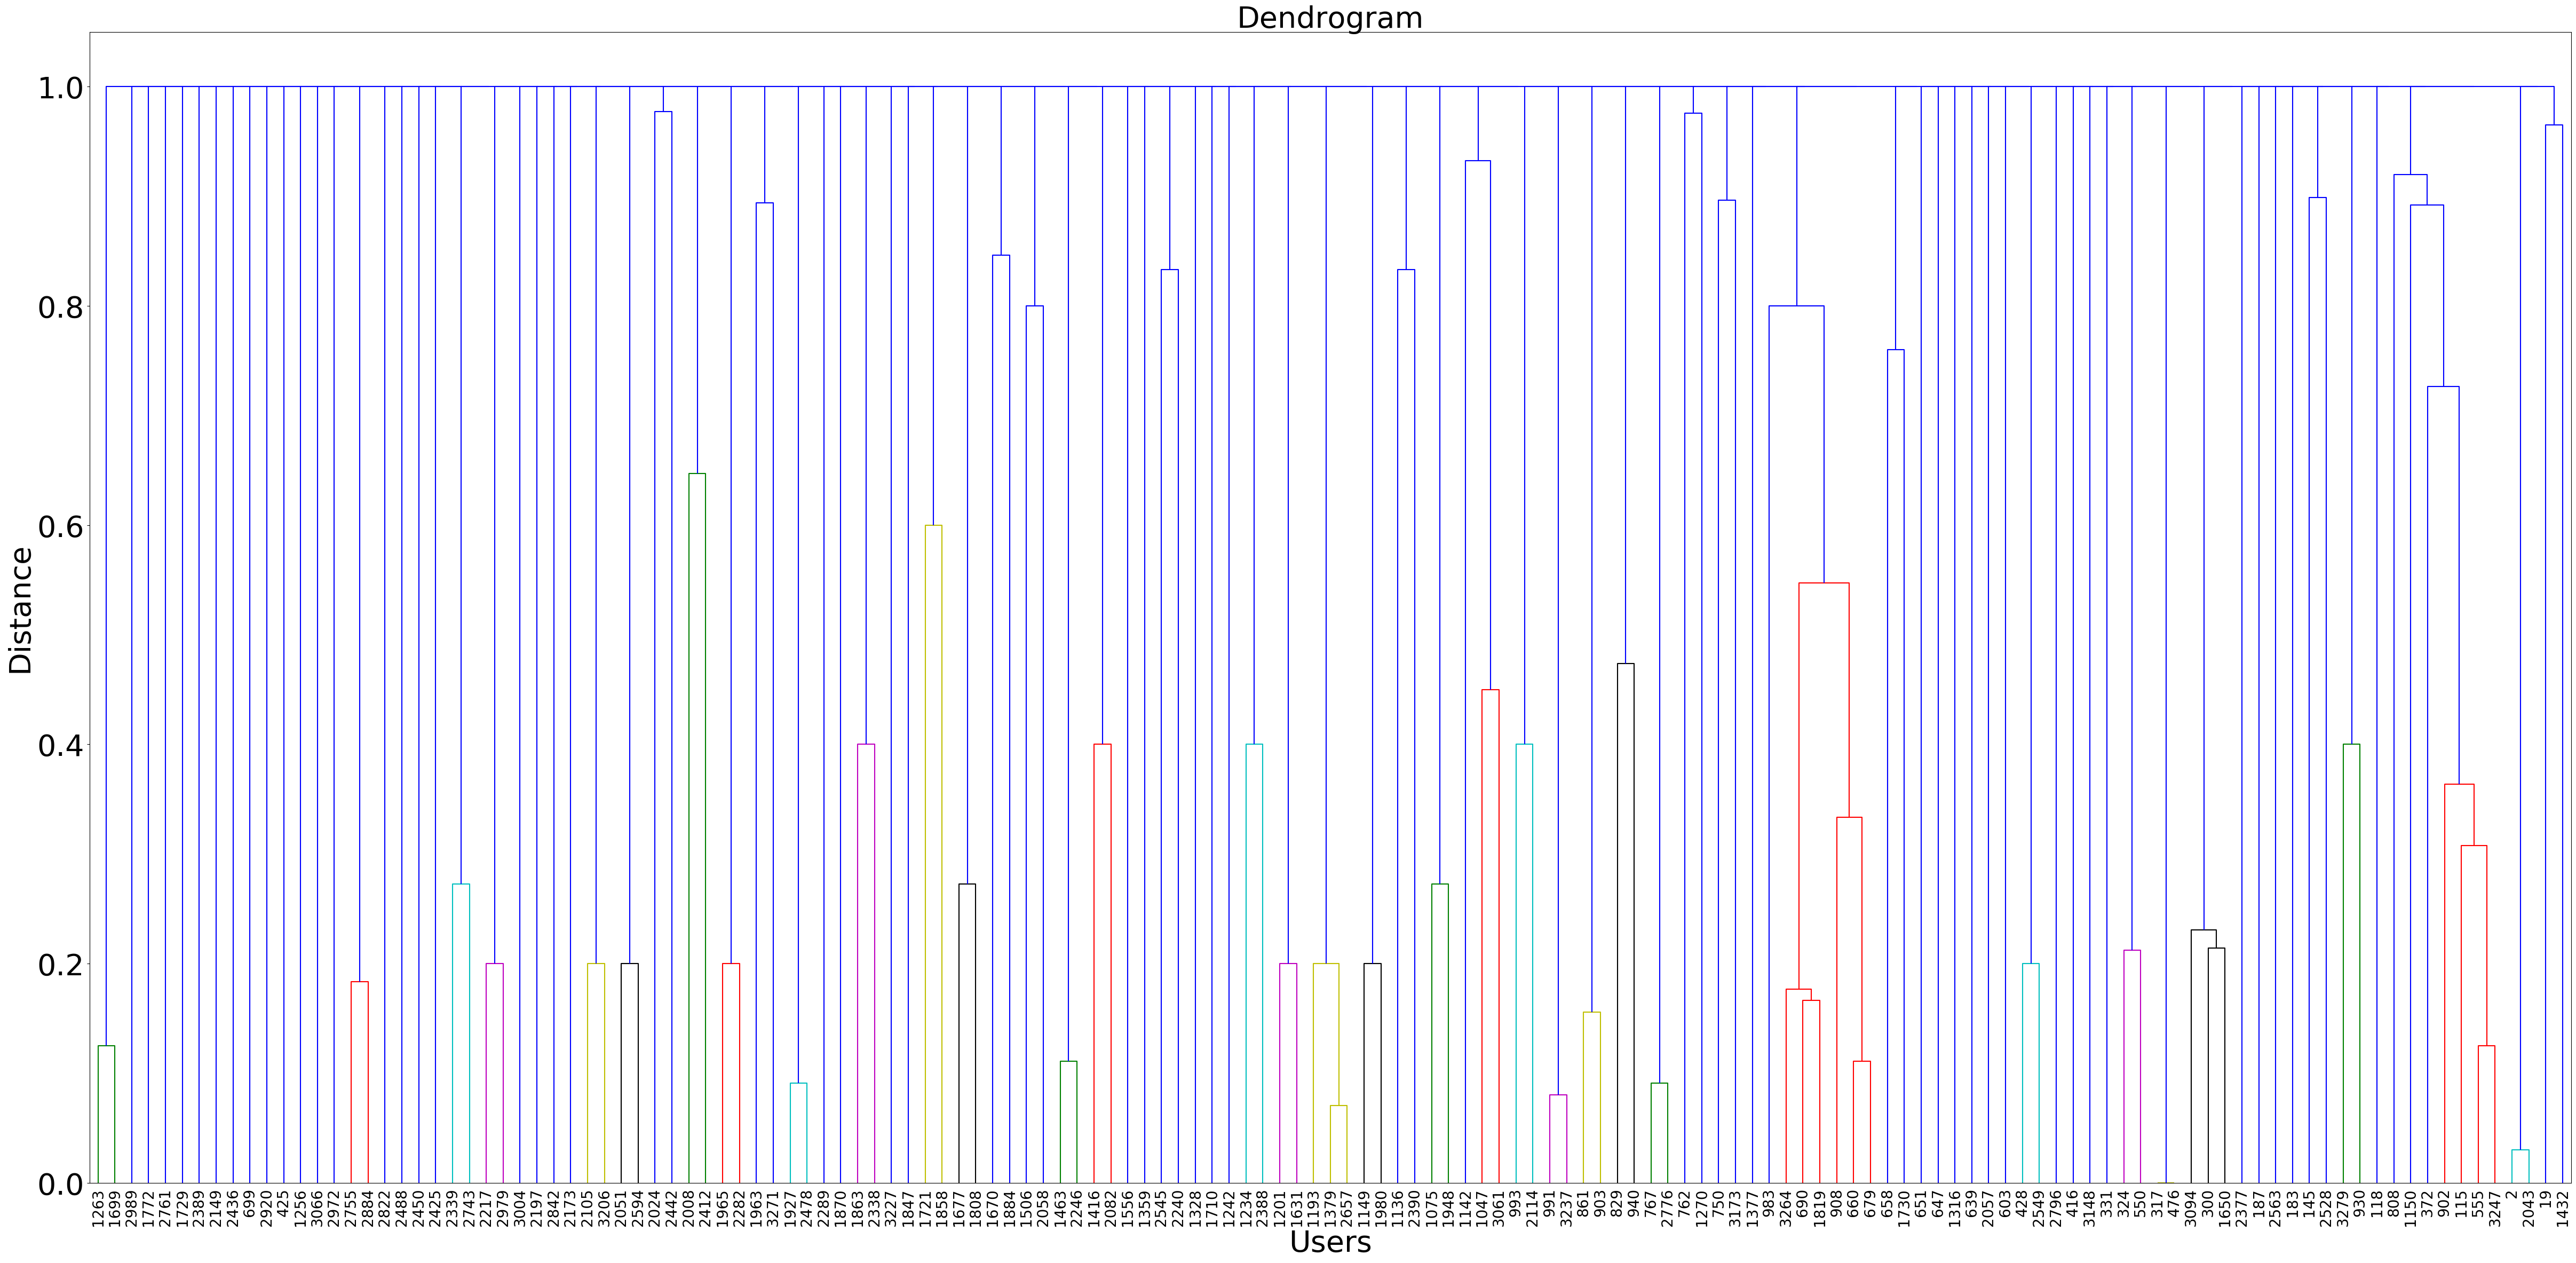

In [29]:
plt.figure(figsize=(60, 28))  

print(np.shape(distance_matrix))

square = ssd.squareform(distance_matrix)

linkage = sch.linkage(square, method='single')

dend = sch.dendrogram(linkage, labels=users_in_common, leaf_rotation=90)

plt.title("Dendrogram", size=40)  
plt.xlabel('Users', size=40)
plt.ylabel('Distance', size=40)
plt.xticks(size = 20)
plt.yticks(size = 40)

plt.savefig(str(tol) + '/' + str(trimming) + '-dendrogram.png')

plt.show()

In [30]:
type_array = type_separation(all_selected_users, all_time_differences, tol)

type_array = np.array(type_array)
user_score_difference = np.array(user_score_difference)

total_exercises = type_array[:, 3]
type_array = np.reshape(type_array[:, 2], (-1, 1))
user_score_difference = np.reshape(user_score_difference, (-1, 1))

analysing_data = np.concatenate((type_array, user_score_difference), axis=1)

analysing_data = np.array(analysing_data, np.float)

user_pairs_copy = user_pairs.copy()

i = 0
while i < len(analysing_data):
    if(np.isnan(analysing_data[i,1])):
        user_pairs_copy.pop(i)
        analysing_data = np.delete(analysing_data, i, 0)
        total_exercises = np.delete(total_exercises, i, 0)
    else:
        i = i + 1

print("Finished")

Rearranging...
Analysis finished.
Finished


## Scatter plot

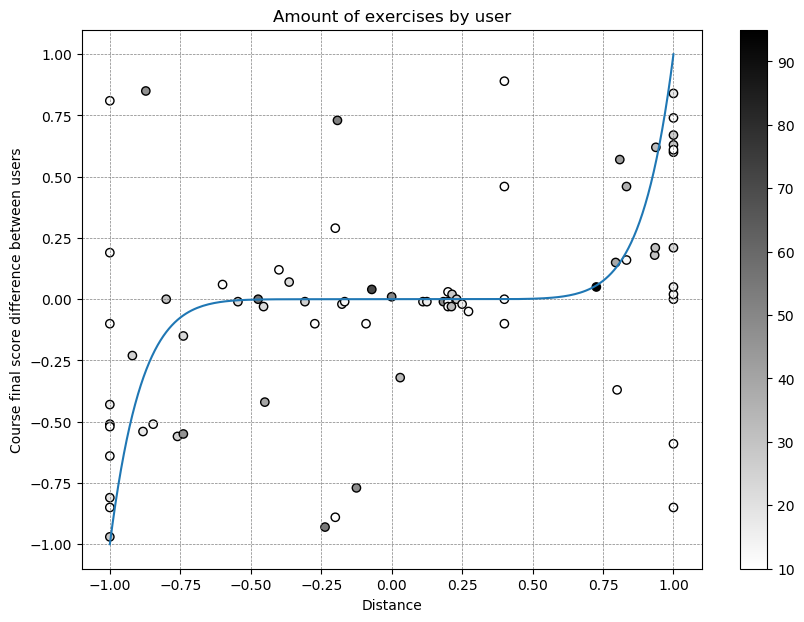

In [31]:
plt.figure(figsize=(10, 7))
plt.xlabel('Distance')
plt.ylabel('Course final score difference between users')
plt.title("Amount of exercises by user")

scatter = plt.scatter(analysing_data[:, 0], analysing_data[:, 1], edgecolors = 'black', c=total_exercises, cmap='binary')

plt.colorbar(scatter)

#for i, txt in enumerate(user_pairs_copy):
#    plt.annotate(txt, (analysing_data[i, 0], analysing_data[i, 1]))

x = np.linspace(-1, 1, 201)
y = [pow(i, 9) for i in x]
plt.plot(x, y)

axes = plt.gca()
axes.set_xlim([-1.1, 1.1])
axes.set_ylim([-1.1, 1.1])

plt.grid(color='grey', linestyle='--', linewidth=.5)

plt.savefig(str(tol) + '/' + str(trimming) + '-amount_of_exercises.png')

plt.show()

## Distance from optimal curve (X^9)

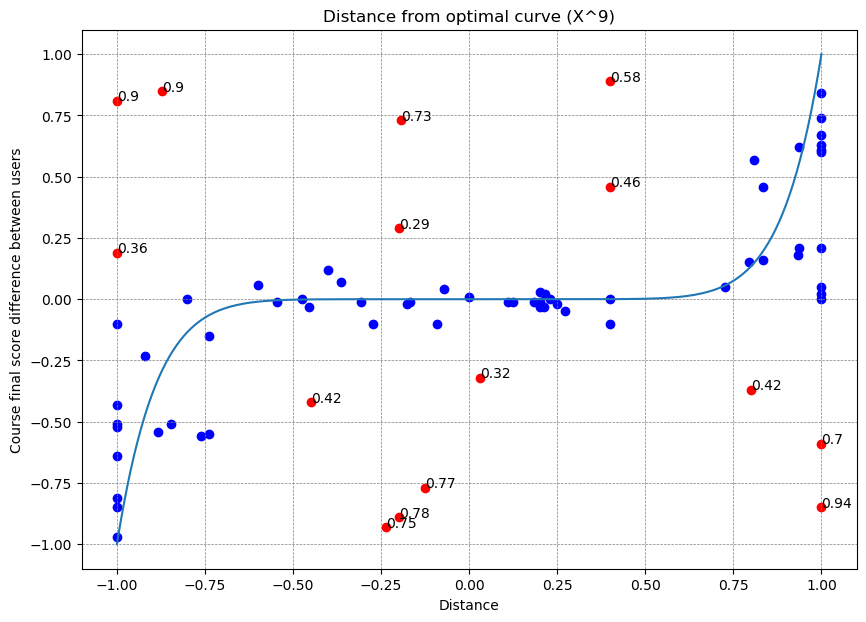

In [32]:
plt.figure(figsize=(10, 7))
plt.xlabel('Distance')
plt.ylabel('Course final score difference between users')
plt.title("Distance from optimal curve (X^9)")

normal_points = []
outliers = []

for i, txt in enumerate(analysing_data):
    dist = distance(analysing_data[i, 0], analysing_data[i, 1])
    if (dist > 0.25):
        plt.annotate(round(dist, 2), (analysing_data[i, 0], analysing_data[i, 1])) 
        outliers.append([analysing_data[i, 0], analysing_data[i, 1], user_pairs_copy[i][0], user_pairs_copy[i][1]])
    else:
        normal_points.append([analysing_data[i, 0], analysing_data[i, 1], user_pairs_copy[i][0], user_pairs_copy[i][1]])

#for i, txt in enumerate(user_pairs_copy):
#    plt.annotate(txt, (analysing_data[i, 0], analysing_data[i, 1]))

normal_points = np.asarray(normal_points)
outliers = np.asarray(outliers)
        
plt.scatter(normal_points[:, 0], normal_points[:, 1], marker='o', color='blue', picker=True)   
plt.scatter(outliers[:, 0], outliers[:, 1], marker='o', color='red', picker=True)    

x = np.linspace(-1, 1, 201)
y = [pow(i, 9) for i in x]
plt.plot(x, y)

axes = plt.gca()
axes.set_xlim([-1.1, 1.1])
axes.set_ylim([-1.1, 1.1])

plt.grid(color='grey', linestyle='--', linewidth=.5)

plt.savefig(str(tol) + '/' + str(trimming) + '-distance_from_curve.png')

plt.show()

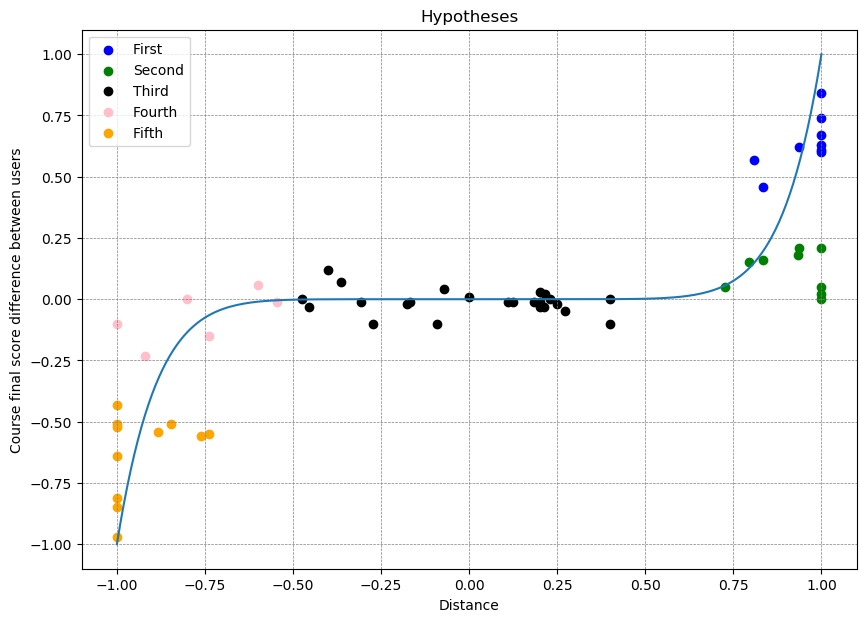

In [33]:
first = []
second = []
third = []
fourth = []
fifth = []
others = []

plt.figure(figsize=(10, 7))
plt.xlabel('Distance')
plt.ylabel('Course final score difference between users')
plt.title("Hypotheses")

for i in range(0, len(normal_points)):
    d = normal_points[i, 0]
    sc = normal_points[i, 1]
              
    if (d >= 0.5 and sc >= 0.25):
        first.append([d, sc])
    elif (d >= 0.5 and sc > -0.25 and sc < 0.25):
        second.append([d, sc])
    elif (d > -0.5 and d < 0.5 and sc > -0.25 and sc < 0.25):
        third.append([d, sc])
    elif (d <= -0.5 and sc > -0.25 and sc < 0.25):
        fourth.append([d, sc])
    elif (d <= 0.5 and sc <= 0.25):
        fifth.append([d, sc])
    else:
        others.append([d, sc])
        
first = np.asarray(first)
second = np.asarray(second)
third = np.asarray(third)
fourth = np.asarray(fourth)
fifth = np.asarray(fifth)
others = np.asarray(others)
        
plt.scatter(first[:, 0], first[:, 1], marker='o', color='blue', label='First', picker=True)
plt.scatter(second[:, 0], second[:, 1], marker='o', color='green', label='Second', picker=True)
plt.scatter(third[:, 0], third[:, 1], marker='o', color='black', label='Third', picker=True)
plt.scatter(fourth[:, 0], fourth[:, 1], marker='o', color='pink', label='Fourth', picker=True)
plt.scatter(fifth[:, 0], fifth[:, 1], marker='o', color='orange', label='Fifth', picker=True)

x = np.linspace(-1, 1, 201)
y = [pow(i, 9) for i in x]
plt.plot(x, y)

axes = plt.gca()
axes.set_xlim([-1.1, 1.1])
axes.set_ylim([-1.1, 1.1])
axes.legend()

plt.grid(color='grey', linestyle='--', linewidth=.5)

plt.savefig(str(tol) + '/' + str(trimming) + '-hypotheses.png')

plt.show()

## Checking outliers

In [34]:
array_being_analysed = outliers

In [35]:
ip_addrs = check_ip_addresses(array_being_analysed, df)

ips_in_common = []

for i in range(0, len(ip_addrs)):
    user_1_ips = ip_addrs[i][0]
    user_2_ips = ip_addrs[i][1]
    count_1 = ip_addrs[i][2]
    count_2 = ip_addrs[i][3]
    amount = 0
    for j in range(0, len(user_1_ips)):
        for k in range(0, len(user_2_ips)):
            if ((user_1_ips[j] == user_2_ips[k]) == True):
                amount = amount + min(count_1[j], count_2[k])
    #print('-'*100)
    #print('User 1 (', array_being_analysed[i][2], ',', len(user_1_ips), '): ', user_1_ips, count_1)
    #print('User 2 (', array_being_analysed[i][3], ',', len(user_2_ips), '): ', user_2_ips, count_2)
    #print('\nCorrelation: ', amount, np.intersect1d(user_1_ips, user_2_ips, assume_unique=True))
    ips_in_common.append(amount)

94 % done


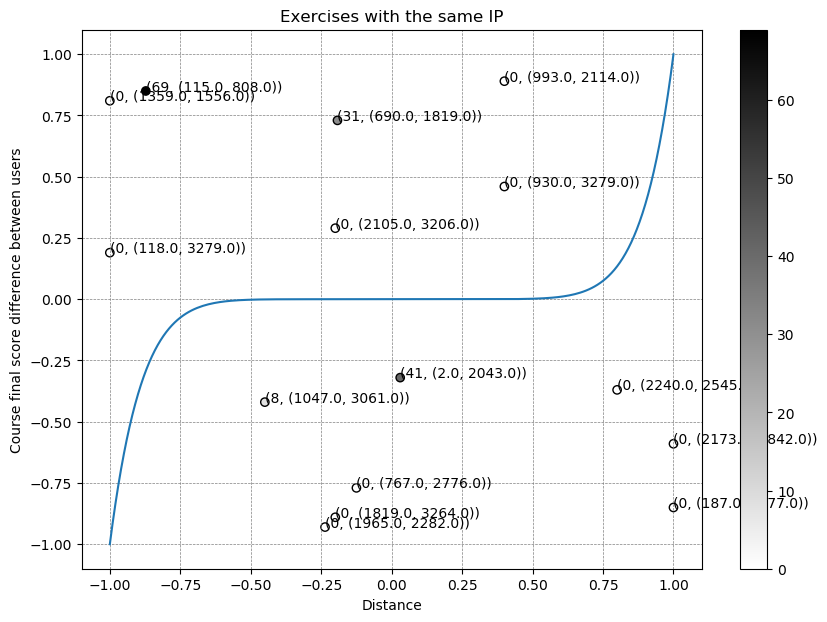

In [36]:
plt.figure(figsize=(10, 7))
plt.xlabel('Distance')
plt.ylabel('Course final score difference between users')
plt.title("Exercises with the same IP")

scatter = plt.scatter(array_being_analysed[:, 0], array_being_analysed[:, 1], edgecolors = 'black', c=ips_in_common, cmap='binary')

plt.colorbar(scatter)

for i, txt in enumerate(ips_in_common):
    plt.annotate((txt, (array_being_analysed[i, 2], array_being_analysed[i, 3])), (array_being_analysed[i, 0], array_being_analysed[i, 1]))

x = np.linspace(-1, 1, 201)
y = [pow(i, 9) for i in x]
plt.plot(x, y)

axes = plt.gca()
axes.set_xlim([-1.1, 1.1])
axes.set_ylim([-1.1, 1.1])

plt.grid(color='grey', linestyle='--', linewidth=.5)

plt.savefig(str(tol) + '/' + str(trimming) + '-exercises_same_ip.png')

plt.show()

In [37]:
interactions = check_interactions(array_being_analysed, df)

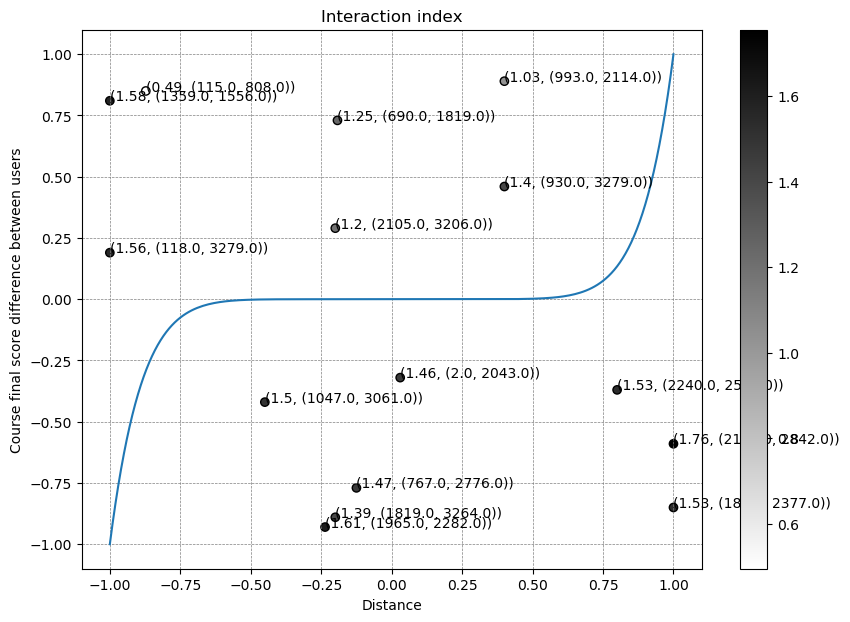

In [38]:
plt.figure(figsize=(10, 7))
plt.xlabel('Distance')
plt.ylabel('Course final score difference between users')
plt.title("Interaction index")

interactions_sum = interactions[:, 0] + interactions[:, 1]

scatter = plt.scatter(array_being_analysed[:, 0], array_being_analysed[:, 1], edgecolors = 'black', c=interactions_sum, cmap='binary')

plt.colorbar(scatter)

for i, txt in enumerate(interactions_sum):
    plt.annotate((round(txt, 2), (array_being_analysed[i, 2], array_being_analysed[i, 3])), (array_being_analysed[i, 0], array_being_analysed[i, 1]))

x = np.linspace(-1, 1, 201)
y = [pow(i, 9) for i in x]
plt.plot(x, y)

axes = plt.gca()
axes.set_xlim([-1.1, 1.1])
axes.set_ylim([-1.1, 1.1])

plt.grid(color='grey', linestyle='--', linewidth=.5)

plt.savefig(str(tol) + '/' + str(trimming) + '-interaction_index.png')

plt.show()